# Community EDA

In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [2]:
import re
import pickle
import json
import random
from itertools import islice
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple, Union, Dict

import numpy as np
from tqdm.auto import tqdm

import vec4gloss
from vec4gloss import check_hashes    
from vec4gloss import (
    DepWinOutput, AnnotDepInfo,
    AnnotFrameInfo, NounFrameInfo
)

## Data dependencies

```
30.23 => ..\data\annot_frameinfo_list.pkl f25b87
30.26 => ..\data\nouns_vec4gloss_frameinfo_list.pkl 9ad739
```

In [3]:
annot_info_path = "../data/annot_frameinfo_list.pkl"
noun_info_path = "../data/nouns_vec4gloss_frameinfo_list.pkl"
_ = check_hashes([annot_info_path, noun_info_path])

..\data\annot_frameinfo_list.pkl f25b87
..\data\nouns_vec4gloss_frameinfo_list.pkl 9ad739


## Load resources

In [4]:
annot_infos = pickle.loads(Path(annot_info_path).read_bytes())
noun_infos = pickle.loads(Path(noun_info_path).read_bytes())

In [5]:
len(annot_infos), len(noun_infos)

(244, 20)

In [6]:
annot_infos[1], noun_infos[1]

(AnnotFrameInfo(annot_frame=AnnotFrame(sense_id=5071201, POS='D', head_word='實地', definition='表親身體驗後述事件。', event_role='patient ', schemas=[Scheme(type='--', start=0, end=1), Scheme(type='mod', start=1, end=3), Scheme(type='action', start=3, end=5), Scheme(type='event', start=5, end=9)]), dep_info=[<AnnotDepInfo (2) 1.00: ( 3- 3) [ 0.00/1.00] 　表 / >, <AnnotDepInfo (3) 0.00: ( 3- 4) [ 0.56/0.00] 　親 / 表>, <AnnotDepInfo (4) 0.91: ( 3- 5) [ 2.32/0.39] 　身 / 表親>, <AnnotDepInfo (5) 0.02: ( 3- 4) [ 1.32/0.01] 　體 / 表>, <AnnotDepInfo (6) 1.00: ( 3- 5) [24604.15/0.00] 　驗 / 表親>, <AnnotDepInfo (7) 0.00: ( 3- 8) [43.86/0.00] 　後 / 表親身體驗>, <AnnotDepInfo (8) 0.02: ( 3- 4) [ 3.26/0.01] 　述 / 表>, <AnnotDepInfo (9) 0.38: ( 7-10) [39.18/0.01] 事件 / 驗後述>]),
 NounFrameInfo(noun_entry={'cwnid': '09167302', 'src': '昨天他派宦官已經暗示過張延賞，今天將由張延賞來挑主<樑>力促此事，但韓卻看破他的企圖，一上來便釜底抽薪，打亂了他地部署。', 'tgt': 'Na。比喻在特定事件中最重要的角色。', 'pos': 'N', 'target': '樑', 'fillers': ['學院', '室友', '弟兄'], 'example': '昨天他派宦官已經暗示過張延賞，今天將由張延賞來挑主<樑>力促此事，但韓卻看破他

In [7]:
annot_x = annot_infos[1]

In [8]:
annot_x.dep_info

[<AnnotDepInfo (2) 1.00: ( 3- 3) [ 0.00/1.00] 　表 / >,
 <AnnotDepInfo (3) 0.00: ( 3- 4) [ 0.56/0.00] 　親 / 表>,
 <AnnotDepInfo (4) 0.91: ( 3- 5) [ 2.32/0.39] 　身 / 表親>,
 <AnnotDepInfo (5) 0.02: ( 3- 4) [ 1.32/0.01] 　體 / 表>,
 <AnnotDepInfo (6) 1.00: ( 3- 5) [24604.15/0.00] 　驗 / 表親>,
 <AnnotDepInfo (7) 0.00: ( 3- 8) [43.86/0.00] 　後 / 表親身體驗>,
 <AnnotDepInfo (8) 0.02: ( 3- 4) [ 3.26/0.01] 　述 / 表>,
 <AnnotDepInfo (9) 0.38: ( 7-10) [39.18/0.01] 事件 / 驗後述>]

In [9]:
tok_idx = 7
(annot_x.dep_info[tok_idx].full_token_prob(), 
annot_x.dep_info[tok_idx].fullmasked_token_prob(),
annot_x.dep_info[tok_idx].nodep_token_prob())

(0.38073739409446716, 0.11672204732894897, 0.009717438369989395)

## Two parameters
* mu: a semantic parameters, what happens if all previous tokens are masked out
* lambda: a syntactic dependency parameters, what happen if the dependet tokens are masked out. This is the worst score possible in a given window.

In [10]:
class TokenParam:
    def __init__(self, token_dep_info: AnnotDepInfo):
        self.dep_info = token_dep_info
        self.full_prob = token_dep_info.full_token_prob()
        self.masked_prob = token_dep_info.fullmasked_token_prob()
        self.nodep_prob = token_dep_info.nodep_token_prob()
    
    def __repr__(self):
        return "<TokenLambda {:}: μ={:.1f}, λ={:.1f}>".format(
            self.token(),
            self.get_mu(),
            self.get_lambda()
        )
    
    def token(self):
        return self.dep_info.dep_wins[0].token_text
    
    def get_mu(self):
        return -np.log(self.masked_prob / self.full_prob)
    
    def get_lambda(self):
        return -np.log(self.nodep_prob / self.full_prob)
    
    def get_token_prob(self):
        return self.full_prob

In [11]:
annot_x.dep_info[7]

<AnnotDepInfo (9) 0.38: ( 7-10) [39.18/0.01] 事件 / 驗後述>

In [12]:
TokenParam(annot_x.dep_info[7])

<TokenLambda 事件: μ=1.2, λ=3.7>

In [13]:
TokenStr = str
ParamBufDict = Dict[str, List[float]]

In [14]:
def compute_token_params(
        frame_infos:Union[List[AnnotFrameInfo], List[NounFrameInfo]]
        ) -> Dict[TokenStr, ParamBufDict]:
    params = {}
    for frame_x in frame_infos:
        for token_info in frame_x.dep_info:
            token_param = TokenParam(token_info)
            token = token_param.token()
            p_prob = token_param.get_token_prob()
            p_mu = token_param.get_mu()
            p_lambda = token_param.get_lambda()
            buf = params.setdefault(token, {"mu": [], "lambda": [], "prob": []})
            buf["prob"].append(p_prob)
            buf["mu"].append(p_mu)
            buf["lambda"].append(p_lambda)
            
    return params

In [15]:
def compute_param_stats(
        params: Dict[TokenStr, ParamBufDict]):
    stats = []
    for tok, params in params.items():
        probs = params["prob"]
        mus = params["mu"]
        lambdas = params["lambda"]
        if len(mus) < 2: continue
        stats.append((
            tok, np.mean(probs), np.mean(mus), np.mean(lambdas),
            np.std(probs, ddof=1),
            np.std(mus, ddof=1), 
            np.std(lambdas, ddof=1)))
    return stats

In [16]:

adv_token_params = compute_token_params(annot_infos)
noun_token_params = compute_token_params(noun_infos)
adv_token_stat = compute_param_stats(adv_token_params)
noun_token_stat = compute_param_stats(noun_token_params)

## What's the relations between mu and lambda ?? 

In [17]:
import pandas as pd
cols = "tok,prob_avg,mu_avg,lambda_avg,prob_sd,mu_sd,lambda_sd"
adv_stat_df = pd.DataFrame.from_records(adv_token_stat, 
                                        columns=cols.split(","))
noun_stat_df = pd.DataFrame.from_records(noun_token_stat, 
                                        columns=cols.split(","))

<AxesSubplot:xlabel='mu_avg', ylabel='lambda_avg'>

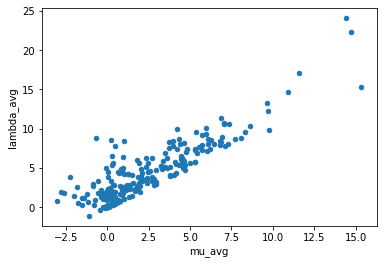

In [18]:
adv_stat_df.plot.scatter("mu_avg", "lambda_avg")

<AxesSubplot:xlabel='mu_avg', ylabel='lambda_avg'>

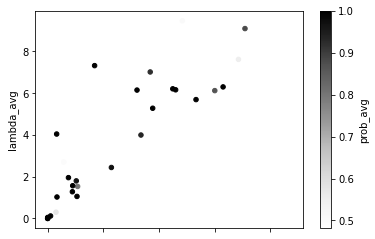

In [20]:
noun_stat_df.plot.scatter("mu_avg", "lambda_avg", c="prob_avg")

In [21]:
adv_stat_df[adv_stat_df.prob_avg>0.9].sort_values("lambda_avg", ascending=False).iloc[:10]

,tok,prob_avg,mu_avg,lambda_avg,prob_sd,mu_sd,lambda_sd
139,之前,0.983682,11.594708,17.038592,2.293412e-02,5.013798,0.673042
122,性質,0.999999,15.358076,15.358076,6.743496e-07,0.582032,0.582032
36,之中,0.996450,10.925147,14.673599,5.020111e-03,3.913743,6.522220
75,下,0.961075,7.059066,10.634715,5.661921e-02,1.970033,1.307805
170,性,0.989164,5.965030,10.103617,1.515687e-02,1.821736,3.743194
181,象,0.999996,8.319385,9.632700,7.992902e-06,4.080999,3.306563
189,願,0.962614,5.987500,9.314638,1.352497e-02,4.211090,0.494195
234,利,0.999980,4.658043,8.139091,1.879749e-05,1.903403,0.312083
26,早,0.973277,6.480709,8.033191,4.459030e-02,5.994828,5.604632
187,會,0.980649,6.010746,7.168697,2.733067e-02,2.737159,3.593694


In [22]:
noun_stat_df[noun_stat_df.prob_avg>0.9].sort_values("lambda_avg", ascending=False).iloc[:10]

,tok,prob_avg,mu_avg,lambda_avg,prob_sd,mu_sd,lambda_sd
18,成的,0.995363,1.686324,7.319915,0.006524,1.281319,3.001861
10,或,0.918979,3.683529,7.015944,0.089840,1.207723,4.277750
28,參,0.999664,6.300191,6.300191,0.000302,2.180331,2.180331
6,而,0.996813,4.493993,6.208979,0.002308,1.455160,1.931671
9,象,0.999995,4.596065,6.161366,0.000008,3.754348,2.330785
19,狀,0.996519,3.208919,6.148512,0.005394,2.933798,3.552246
20,界,0.998915,5.328576,5.692723,0.001511,7.465117,7.537744
16,為,0.998021,3.772430,5.278449,0.002997,3.911105,4.424743
15,位,0.999959,0.322887,4.042622,0.000071,0.411260,3.288765
8,對,0.933636,3.350592,3.994975,0.139007,4.629182,5.583200


In [23]:
noun_stat_df[noun_stat_df.prob_avg>0.9].sort_values("mu_avg", ascending=False).iloc[:10]

,tok,prob_avg,mu_avg,lambda_avg,prob_sd,mu_sd,lambda_sd
28,參,0.999664,6.300191,6.300191,0.000302,2.180331,2.180331
20,界,0.998915,5.328576,5.692723,0.001511,7.465117,7.537744
9,象,0.999995,4.596065,6.161366,0.000008,3.754348,2.330785
6,而,0.996813,4.493993,6.208979,0.002308,1.455160,1.931671
16,為,0.998021,3.772430,5.278449,0.002997,3.911105,4.424743
10,或,0.918979,3.683529,7.015944,0.089840,1.207723,4.277750
8,對,0.933636,3.350592,3.994975,0.139007,4.629182,5.583200
19,狀,0.996519,3.208919,6.148512,0.005394,2.933798,3.552246
14,單,0.969567,2.288510,2.440198,0.052648,3.809423,3.690595
18,成的,0.995363,1.686324,7.319915,0.006524,1.281319,3.001861


### Observations
* The two parameters are highly correlated, as they should be. The full masked probability is generally lower than the dependent mask probability.
* If so, maybe just use one parameter, mu, to indicate the overall influence of the preceding decoding context.
* A by-type statistics looks smearing the pattern, how about a token-based view?

## How about Flatten it
* A by-token view

In [24]:
def compute_token_params_flatten(
        frame_infos:Union[List[AnnotFrameInfo], List[NounFrameInfo]]
        ) -> List[Tuple[TokenStr, int, float, float, float]]:
    params = []
    for frame_x in frame_infos:
        for token_info in frame_x.dep_info:
            token_param = TokenParam(token_info)
            token = token_param.token()
            tok_idx = token_info.tgt_idx
            p_prob = token_param.get_token_prob()
            p_mu = token_param.get_mu()
            p_lambda = token_param.get_lambda()
            params.append((token, tok_idx, p_prob, p_mu, p_lambda))            
            
    return params

In [25]:
adv_token_flattens = compute_token_params_flatten(annot_infos)
noun_token_flattens = compute_token_params_flatten(noun_infos)

In [26]:
flatten_cols = "tok,pos,prob,mu,lambda"
adv_flatten_df = pd.DataFrame.from_records(adv_token_flattens, 
                                        columns=flatten_cols.split(","))
noun_flatten_df = pd.DataFrame.from_records(noun_token_flattens, 
                                        columns=flatten_cols.split(","))

In [27]:
adv_token_flattens[:10]

[('表', 2, 0.9950998425483704, -0.0, -0.0),
 ('勉強', 3, 0.00010534111061133444, -1.041025204900679, -1.041025204900679),
 ('去', 4, 0.00044650971540249884, 1.6028850238532915, 1.6028850238532915),
 ('做', 5, 0.9974549412727356, 3.8372316346569146, 3.8372316346569146),
 ('後', 6, 0.11566287279129028, -0.7465949857885057, 1.2765092651874652),
 ('述', 7, 0.9999997615814209, 0.0014887803673614768, 0.0014887803673614768),
 ('事件', 8, 0.20455294847488403, -0.22757873631886424, 4.943336905077286),
 ('表', 2, 0.9982571005821228, -0.0, -0.0),
 ('親', 3, 0.0003395258099772036, -0.5762332369047684, -0.5762332369047684),
 ('身', 4, 0.9070897102355957, 0.8435071834364626, 0.8435071834364626)]

### Is there a position effect?
* The leading position will tend to have lower mus?
* There are position effects, but only observed before the fifth position in the sequences.

<AxesSubplot:xlabel='pos', ylabel='mu'>

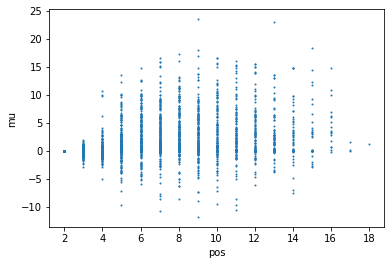

In [28]:
import matplotlib.pyplot as plt
adv_flatten_df.plot.scatter("pos", "mu", s=1)

<AxesSubplot:xlabel='pos', ylabel='mu'>

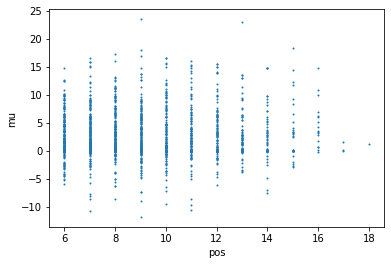

In [29]:
adv_flatten_df[adv_flatten_df.pos>5].plot.scatter("pos", "mu", s=1)

<AxesSubplot:xlabel='pos', ylabel='mu'>

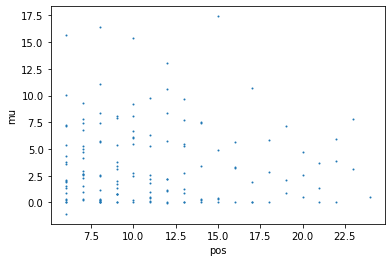

In [30]:
noun_flatten_df[noun_flatten_df.pos>5].plot.scatter("pos", "mu", s=1)